# Exploring the performance of different optimizers for VQE with and without noise. 

In this notebook, you will run a VQE algorithm on the molecular Hydrogen molecule H$_2$ in the minimal basis. Once we set up our algorithm, we will explore the performance of three different classical optimizers: COBYLA, SAPA, and ADAM. We will also see how they perform if we add some amount of noise to the simulator. 

## Setup

First, make sure that you have the latest version of Qiskit installed. To upgrade your Qiskit package, run the following command:

```bash
pip install --upgrade qiskit
```

Get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package `qiskit_ionq` using `pip`:

```bash
pip install qiskit_ionq
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [1]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer

from qiskit_ionq import IonQProvider 

#Call provider and set token value
ionq_provider = IonQProvider(token='my token')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [2]:
ionq_provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

First, we import every library/module that will be needed. We will need quite a bit of them.

In [3]:
import numpy as np

from qiskit import execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, ADAM, L_BFGS_B, SLSQP, SPSA
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.circuit.parametervector import ParameterVectorElement

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

from qiskit_nature.runtime import VQEProgram

from matplotlib import pyplot as plt
%matplotlib inline 

First, let's define the unitary CCSD ansatz. For such a two-electron, four-orbital problem, the UCCSD ansatz could be modeled by just the single parameter $\theta$. This means our Ansatz will be $\left|\Psi\right>=e^{i\theta Y_0X_1X_2X_3}$.

In [4]:
class UCCAnsatz():

    def __init__(self, params, num_particles, num_spin_orbitals):

        # number of qubits 
        self.num_of_qubits = num_spin_orbitals

        # number of parameters
        self.num_params = len(params)

        # parameters
        self.params = []
        for index in range(self.num_params):
            p = Parameter("t"+str(index))
            self.params.append(ParameterVectorElement(p, index))

    def UCC1(self):

        qc = QuantumCircuit(4)

        # basis rotation
        qc.rx(np.pi / 2, 0)
        qc.h(1)
        qc.h(2)
        qc.h(3)

        # parameter theta_0
        qc.cx(0, 1)
        qc.cx(1, 2)
        qc.cx(2, 3)
        qc.rz(self.params[0], 3)
        qc.cx(2, 3)
        qc.cx(1, 2)
        qc.cx(0, 1)

        # basis rotation
        qc.rx(-np.pi / 2, 0)
        qc.h(1)
        qc.h(2)
        qc.h(3)


        return qc

For the next function, we need to form the electronic structure problem, obtain the electronic Hamiltonian, and transform it with the Jordan-Wigner Transformation. We also diagonalize the Hamiltonian classically as a reference value. 

In [5]:
################## Hamiltonian Definition #######################################

def GetHamiltonians(mol):

    # construct the driver
    driver = PySCFDriver(molecule=mol, unit=UnitsType.ANGSTROM, basis='sto6g')

    # the electronic structure problem
    problem = ElectronicStructureProblem(driver)

    # get quantum molecule
    q_molecule = driver.run()

    # classical eigenstate
    np_solver = NumPyMinimumEigensolver()
    np_groundstate_solver = GroundStateEigensolver(QubitConverter(JordanWignerMapper()), np_solver)

    np_result = np_groundstate_solver.solve(problem)
    print(f"Classical results is {np_result.eigenenergies}")

    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # construct a qubit converter
    qubit_converter = QubitConverter(JordanWignerMapper())

    # qubit Operations 
    qubit_op = qubit_converter.convert(second_q_ops[0])

    # return the qubit operations
    return qubit_op


Let's now put things together. The overall circuit is constructed by first initializing the HF state, and applying the UCCSD ansatz. 

In [6]:
def constructAnsatz(params):

    # initialize the HF state
    hf_state = HartreeFock(4, [1, 1], QubitConverter(JordanWignerMapper()))

    # VQE circuit
    ansatz = UCCAnsatz(params, 2, 4).UCC1()

    # add initial state
    ansatz.compose(hf_state, front=True, inplace=True)

    # return the circuit
    return ansatz


Finally, we define a classical optimizer. Here we use the COBYLA optimizer. We pass the parametrized circuit into the qiskit's VQE function, and we set the initial values for the parameter to be zero.  

In [7]:
def runVQE(params, backend_id="qasm_simulator", optimizer_id="COBYLA", noise=None):
    
    molecule = Molecule(geometry=[['H',  [0., 0., 0.]],
                                  ['H', [0., 0., 0.75]]],
                                  charge=0, multiplicity=1)

    # Get Hamiltonian
    qubit_op = GetHamiltonians(molecule)

    # Get classical optimizer
    if (optimizer_id == "COBYLA"):
        optimizer = COBYLA()
    elif (optimizer_id == "SPSA"):
        optimizer = SPSA()
    elif (optimizer_id == "ADAM"):
        optimizer = ADAM()

    # Construct and display ansatz
    ansatz = constructAnsatz(params)
    print('Ansatz :', '\n', ansatz)

    # initial parameters 
    init_params = {}
    for index in range(len(params)):
        p = Parameter("t"+str(index))
        init_params[ParameterVectorElement(p, index)] = 0.0

    # backend 
    if (backend_id == "qasm_simulator"):
        backend = Aer.get_backend("qasm_simulator")
    elif (backend_id == "ionq_qpu"):
        backend = ionq_provider.get_backend("ionq_qpu")

    def job_callback(job_id, job_status, queue_position, job) -> None:
        '''
        Printing logs for debugging.
        The function is the parameter job_callback of QuantumInstance
        :param job_id:
        :param job_status:
        :param queue_position:
        :param job:
        :return:
        '''
        print(f"[API JOB-CALLBACK] Job Id:         {job_id}")
        print(f"[API JOB-CALLBACK] Job status:     {job_status}")
        print(f"[API JOB-CALLBACK] Queue position: {queue_position}")
        print(f"[API JOB-CALLBACK] Job:            {job}")

    ionq_quantum_instance = QuantumInstance(backend=backend, job_callback=job_callback, noise_model=noise)

    counts = []
    values = []
    stds   = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        stds.append(std)

    # VQE algorithm
    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    initial_point = np.array([0.0]),
                    callback=store_intermediate_result,
                    quantum_instance=ionq_quantum_instance)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print("Optimized VQE Energy ", result.eigenvalue.real)
    
    return values, stds

Let's now perform the VQE optimization on a simulator. 

In [8]:
# Execute program with default parameters
eng_hist, error_hist = runVQE([0.0])

Classical results is [-1.85131129-5.48655185e-17j]
Ansatz : 
      ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────────■──┤ Rx(-π/2) ├
     ├───┤└─────────┘┌─┴─┐                                 ┌─┴─┐└──┬───┬───┘
q_1: ┤ H ├───────────┤ X ├──■───────────────────────────■──┤ X ├───┤ H ├────
     ├───┤   ┌───┐   └───┘┌─┴─┐                       ┌─┴─┐├───┤   └───┘    
q_2: ┤ X ├───┤ H ├────────┤ X ├──■─────────────────■──┤ X ├┤ H ├────────────
     ├───┤   └───┘        └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘            
q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(t0[0]) ├┤ X ├┤ H ├─────────────────
     └───┘                     └───┘└───────────┘└───┘└───┘                 
Optimized VQE Energy  -1.8408525893172867


Let's plot the optimization process. 

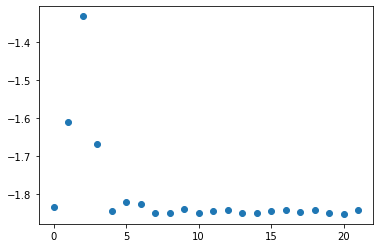

In [9]:
plt.plot([*range(len(eng_hist))], eng_hist, linestyle="", marker="o")
#plt.plot([*range(len(eng_hist))], eng_hist)
plt.show()

As we can see, the energy eigenvalues, VQE returned got smaller and smaller. Our VQE algorithm is working! Notice that I used the default parameters above, which means that that the default classical optimizer COBYLA was used. Now let's change to the SPSA optimizer and see how it performs.

In [10]:
eng_hist_SPSA, error_hist_SPSA = runVQE([0.0],optimizer_id="SPSA")

Classical results is [-1.85131129+6.43595126e-18j]
Ansatz : 
      ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────────■──┤ Rx(-π/2) ├
     ├───┤└─────────┘┌─┴─┐                                 ┌─┴─┐└──┬───┬───┘
q_1: ┤ H ├───────────┤ X ├──■───────────────────────────■──┤ X ├───┤ H ├────
     ├───┤   ┌───┐   └───┘┌─┴─┐                       ┌─┴─┐├───┤   └───┘    
q_2: ┤ X ├───┤ H ├────────┤ X ├──■─────────────────■──┤ X ├┤ H ├────────────
     ├───┤   └───┘        └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘            
q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(t0[0]) ├┤ X ├┤ H ├─────────────────
     └───┘                     └───┘└───────────┘└───┘└───┘                 
Optimized VQE Energy  -1.854267828124676


Now let's compare COBYLA and SPSA. 

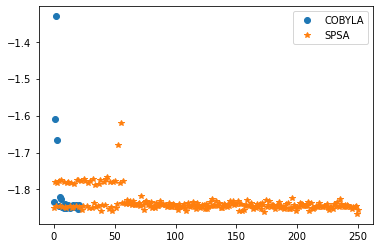

In [11]:
plt.plot([*range(len(eng_hist))], eng_hist, linestyle="", marker="o", label="COBYLA")
plt.plot([*range(len(eng_hist_SPSA))], eng_hist_SPSA, linestyle="", marker="*", label="SPSA")
plt.legend()
plt.show()

As you could see, SPSA converges to the same point as COBYLA, however, it needs many more iterations to do so. 

Let's now try to use the ADAM optimizer, which is a very popular optimizer used in machine learning to train deep neural networks. 

In [12]:
eng_hist_ADAM, error_hist_ADAM = runVQE([0.0],optimizer_id="ADAM")

Classical results is [-1.85131129-4.98381686e-18j]
Ansatz : 
      ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────────■──┤ Rx(-π/2) ├
     ├───┤└─────────┘┌─┴─┐                                 ┌─┴─┐└──┬───┬───┘
q_1: ┤ H ├───────────┤ X ├──■───────────────────────────■──┤ X ├───┤ H ├────
     ├───┤   ┌───┐   └───┘┌─┴─┐                       ┌─┴─┐├───┤   └───┘    
q_2: ┤ X ├───┤ H ├────────┤ X ├──■─────────────────■──┤ X ├┤ H ├────────────
     ├───┤   └───┘        └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘            
q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(t0[0]) ├┤ X ├┤ H ├─────────────────
     └───┘                     └───┘└───────────┘└───┘└───┘                 
Optimized VQE Energy  -1.8314560159761781


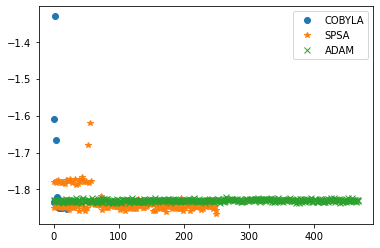

In [13]:
plt.plot([*range(len(eng_hist))], eng_hist, linestyle="", marker="o", label="COBYLA")
plt.plot([*range(len(eng_hist_SPSA))], eng_hist_SPSA, linestyle="", marker="*", label="SPSA")
plt.plot([*range(len(eng_hist_ADAM))], eng_hist_ADAM, linestyle="", marker="x", label="ADAM")
plt.legend()
plt.show()

Interestingly, we find that ADAM does not work very well here. It converges to a much higher value than COBYLA and SPSA. 

So far, we've been running optimizations on noise-free simulators. Quantum Computers are inherently noisy. Let's try to simulate an actual quantum computer. We will do this by adding noise to the simulator and seeing how different optimizers perform under noise. We add 0.5% of error for single qubit rotation gates, and we add 5% of error for CNOT gate. 

In [14]:
# Noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error

# default noise model, can be overridden using set_noise_model
noise = NoiseModel()
# Add depolarizing error to all single qubit gates with error rate 0.5%
one_qb_error = 0.005
noise.add_all_qubit_quantum_error(depolarizing_error(one_qb_error, 1), ['u1', 'u2', 'u3'])

# Add depolarizing error to all two qubit gates with error rate 5.0%
two_qb_error = 0.05
noise.add_all_qubit_quantum_error(depolarizing_error(two_qb_error, 2), ['cx'])

Perform VQE optimization using the same three optimizers. 

In [15]:
eng_hist, error_hist = runVQE([0.0],optimizer_id="COBYLA", noise=noise)
eng_hist_SPSA, error_hist_SPSA = runVQE([0.0],optimizer_id="SPSA", noise=noise)
eng_hist_ADAM, error_hist_ADAM = runVQE([0.0],optimizer_id="ADAM", noise=noise)

Classical results is [-1.85131129-4.24277124e-17j]
Ansatz : 
      ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────────■──┤ Rx(-π/2) ├
     ├───┤└─────────┘┌─┴─┐                                 ┌─┴─┐└──┬───┬───┘
q_1: ┤ H ├───────────┤ X ├──■───────────────────────────■──┤ X ├───┤ H ├────
     ├───┤   ┌───┐   └───┘┌─┴─┐                       ┌─┴─┐├───┤   └───┘    
q_2: ┤ X ├───┤ H ├────────┤ X ├──■─────────────────■──┤ X ├┤ H ├────────────
     ├───┤   └───┘        └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘            
q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(t0[0]) ├┤ X ├┤ H ├─────────────────
     └───┘                     └───┘└───────────┘└───┘└───┘                 
Optimized VQE Energy  -1.6504555139349555
Classical results is [-1.85131129+1.16196667e-17j]
Ansatz : 
      ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────────■──

Let's plot the results. 

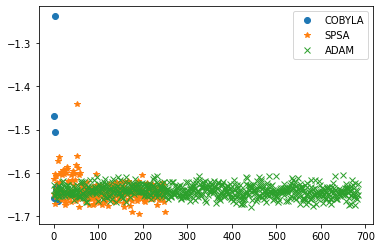

In [16]:
plt.plot([*range(len(eng_hist))], eng_hist, linestyle="", marker="o", label="COBYLA")
plt.plot([*range(len(eng_hist_SPSA))], eng_hist_SPSA, linestyle="", marker="*", label="SPSA")
plt.plot([*range(len(eng_hist_ADAM))], eng_hist_ADAM, linestyle="", marker="x", label="ADAM")
plt.legend()
plt.show()

### Now, let's try the same thing on actual IonQ hardware!
As we can see, with noise, the SPSA optimizer seems to converge to the lowest value. Let's see what happens when we run our VQE algorithm on an actual quantum computer, a system that is inherently noisy.

In [17]:
# run("ionq_qpu")

In [18]:
# opt_process_exp = [-1.8112359199652812, -1.4416498480789817, -1.2335035452225904, -1.4989706208229303, -1.6937521890989031, -1.6557546667316045, -1.6898027909394815, -1.740016937435431, -1.7592133266130963, -1.755505060521276, -1.7199835843097526, -1.7476529655074913, -1.7142357090197362, -1.7366022956905651, -1.7307574124517149, -1.7437590702130892, -1.721561556686939]
# plt.plot(opt_process, linestyle="", marker="o", color="b", label="simulator")
# plt.plot(opt_process_exp, linestyle="", marker="o", color="r", label="ionq_qpu")
# plt.legend()
# plt.show()

In [ ]:
eng_hist, error_hist = runVQE([0.0],optimizer_id="COBYLA", backend_id = "ionq_qpu")
eng_hist_SPSA, error_hist_SPSA = runVQE([0.0],optimizer_id="SPSA", backend_id = "ionq_qpu")
eng_hist_ADAM, error_hist_ADAM = runVQE([0.0],optimizer_id="ADAM", backend_id = "ionq_qpu")

In [ ]:
plt.plot([*range(len(eng_hist))], eng_hist, linestyle="", marker="o", label="COBYLA")
plt.plot([*range(len(eng_hist_SPSA))], eng_hist_SPSA, linestyle="", marker="*", label="SPSA")
plt.plot([*range(len(eng_hist_ADAM))], eng_hist_ADAM, linestyle="", marker="x", label="ADAM")
plt.legend()
plt.show()

As you can see, due to noise on the QPU, it converges to a much higher energy than that of the simulator. 